<a href="https://colab.research.google.com/github/russodanielp/intro_cheminformatics/blob/google_colab/Lab%2007%20-%20Machine%20Learning%20-%20Unsupervised/colab_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

## Aim of this lab

To apply unsupervised machine learning approaches to drug discovery. 

### Objectives

* Understand unsupervised learning and Principal Component Analysis
* Cluster chemicals using the Butina clustering method


## Background


Principal Component Analysis (PCA) is a diminsionality reduction technique popular for visualizing high dimensional data.  Chemical space, created by chemical descritpors, is often in the hundreds or thousands of dimensions making visualization (in 2 or 3D) impossible.  Often, to get an idea of chemical space, we need to reduce this high-dimensional space to 2 or 3 dimensions, which allows us to plot and vizualize as a scatterplot for example.  

PCA works by transforming a raw dataset (i.e., the chemical descrptors) into `n` components, such that the first component, captures the most variance in the dataset, the second captures the second-most under the constraint it is orthogonal to the first, and so on.  The orthoganlity is often kept as it is a more desirable to have non-correlated variables when doing things such as linear regression.  [Here](https://learnche.org/pid/latent-variable-modelling/principal-component-analysis/index) is a good reference for PCA.  

We will use the [DrugBank](https://go.drugbank.com/) to visualize chemical space using PCA, then to identify chemical clusters within the dataset. 

### Descriptors

Similar to calculating chemical similiarity, PCA can be done on any set of descriptors or fingerprints.  However, just like we saw before its important to standardize if your descriptors are not already on the same range.  

In [ ]:
!pip install rdkit
!pip install mols2grid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 20.5 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem 
from rdkit.Chem import PandasTools
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
import pandas as pd
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

from sklearn.preprocessing import StandardScaler

desc_set = ['MolWt', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'MolLogP']

def calc_descriptors_from_frame(df: pd.DataFrame, scale=True, desc_set=None, name_col='compound_id') -> pd.DataFrame:
    """ calculates rdkit descriptors from a smiles.txt file """

    if desc_set:
        desc_set = [desc[0] for desc in Descriptors.descList if desc[0] in desc_set]
    else:
        desc_set = [desc[0] for desc in Descriptors.descList]

    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_set)

    X = pd.DataFrame([list(calc.CalcDescriptors(mol)) for mol in df['ROMol']],
                     columns=list(calc.GetDescriptorNames()),
                     index=df[name_col])
    X = X.loc[X.notnull().all(1), :]

    if scale:
        X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)
    return X


def calc_fingerprints_from_frame(df: pd.DataFrame, kind='ECFP6', name_col='compound_id') -> pd.DataFrame:



    data = []

    for mol in df['ROMol'].values:
        fps = [float(x) for x in AllChem.GetMorganFingerprintAsBitVect(mol,
                                                                         3,
                                                                         1024,
                                                                         useFeatures=True if kind == 'FCFP6' else False)]
        data.append(fps)

    return pd.DataFrame(data, index=df[name_col])

  
def calc_rdkit_fps_from_mol(mol):
    """
    Encode a molecule from a RDKit Mol into a set of descriptors.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    Returns
    -------
    list
        The set of chemical descriptors as a list.

    """
    return Chem.RDKFingerprint(mol)


def cluster_mols_from_frame(df, DIST_CUTOFF=0.3):
  fp_list = []

  for mol in df.ROMol.tolist():
      fp = calc_rdkit_fps_from_mol(mol)
      fp_list.append(fp)

  dists = []
  nfps = len(fp_list)
  for i in range(1, nfps):
      sims = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
      dists.extend([1-x for x in sims])
  mol_clusters = Butina.ClusterData(dists, nfps, DIST_CUTOFF, isDistData=True)
  cluster_id_list = [0]*nfps
  for idx, cluster in enumerate(mol_clusters, 1):
      for member in cluster:
          cluster_id_list[member] = idx
  return [x-1 for x in cluster_id_list]

First load the drugbank dataset...

In [ ]:
df = PandasTools.LoadSDF('drugbank.sdf')
df.head(3)

[16:22:42] WARNING: not removing hydrogen atom without neighbors


,GENERIC_NAME,SYNONYMS,JCHEM_LOGP,FORMULA,ALOGPS_SOLUBILITY,JCHEM_BIOAVAILABILITY,ID,ROMol
0,Perfluoro tert-butylcyclohexane,Oxycyte,6.403324,C10F20,4.75e-02 g/l,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7f68deaf0e40>
1,Dibromothymoquinone,"2,5-dibromo-3-isopropyl-6-methyl-1,4-benzoquin...",3.654123,C10H10Br2O2,1.32e-01 g/l,1.0,,<rdkit.Chem.rdchem.Mol object at 0x7f68deaf0f90>
2,"5-chloro-7-[(1-methylethyl)amino]pyrazolo[1,5-...",nan,1.668743,C10H10ClN5,1.18e-01 g/l,1.0,,<rdkit.Chem.rdchem.Mol object at 0x7f68deaf0f20>


Then, we create chemical descriptors.  Here, we will only use 6 descriptors MolWt, TPSA, NumRotatableBonds, NumHDonors, NumHAcceptors, MolLogP.

In [ ]:
descriptors = calc_descriptors_from_frame(df, name_col='GENERIC_NAME', desc_set=desc_set)

The Machine Learning package `scikit-learn` has functionality for doing Principal Component Analysis (PCA)...

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

latent_space = pca.fit_transform(descriptors)

In [ ]:
latent_space.shape

(8357, 6)

In [ ]:
pca.explained_variance_ratio_

array([0.53672476, 0.29505246, 0.08709729, 0.05755112, 0.01210763,
       0.01146673])

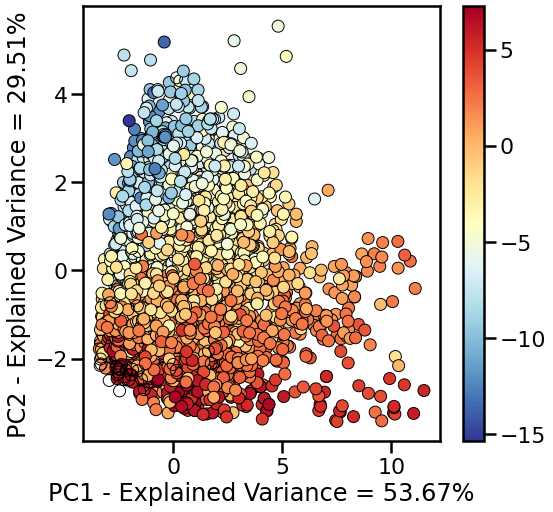

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns, numpy as np

sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,8))

df['Activity'] = np.log(df.ALOGPS_SOLUBILITY.str.replace(' g/l', '').astype(float))

cm = plt.cm.RdYlBu_r
norm = mpl.colors.Normalize(vmin=df['Activity'] .min(), vmax=df['Activity'] .max())
colors = cm(norm(df['Activity']))

scatter = sns.scatterplot(x=latent_space[:, 0], y=latent_space[:, 1], c=[c for c in colors], edgecolor='k')

ax.set_xlabel('PC1 - Explained Variance = {:.2f}%'.format(pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('PC2 - Explained Variance = {:.2f}%'.format(pca.explained_variance_ratio_[1]*100))

sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

fig.colorbar(sm)
plt.show()

## Chemical Clustering

Chemical clustering is useful way to identify sets (or clusters) of chemicals from a larger, diverse dataset of chemicals.  Often times coupled with an interesting chemical property, such as toxicity, it can be used to identify classes of chemicals worthy of further investigative action, like searching for a common molecular target invoking there toxicity.  

There are several different ways of clusters, both specific to chemistry and not, but a well-known method is by using the [Butina algorithm](https://pubs.acs.org/doi/pdf/10.1021/ci9803381) which is available in the RDKit. The Butina algorithm clusters chemicals into groups where every chemical is of a certain similarity to its cluster bretheren.

First we read our chemicals and calcualte chemical descriptors.

In the code below, we cluster our dataset and assign each chemical to a particular cluster number. 

In [ ]:
df['Cluster_assignments'] = cluster_mols_from_frame(df, DIST_CUTOFF=0.3)

We can also created a frame with one chemical (the "centroid") from each cluster.  

In [ ]:
cluster_rows = []
for k,v in df.groupby("Cluster_assignments"):
    cluster_rows.append([v.ROMol.values[0], k, len(v)])
cluster_df = pd.DataFrame(cluster_rows, columns=["mols", "Cluster", "Num_Compounds"])
cluster_df.head(4)

,mols,Cluster,Num_Compounds
0,<rdkit.Chem.rdchem.Mol object at 0x7f68df239cf0>,0,161
1,<rdkit.Chem.rdchem.Mol object at 0x7f68def62900>,1,117
2,<rdkit.Chem.rdchem.Mol object at 0x7f68df239e40>,2,60
3,<rdkit.Chem.rdchem.Mol object at 0x7f68df1896d0>,3,5


The package `mols2grid` allows for interactive tables that display chemicals in a dataframe.  We can display the cluster number and the number of chemicals in the cluster.  In the cell below, can select a cluster for further viewing. 

In [ ]:
import mols2grid

mols2grid.display(cluster_df.sort_values("Num_Compounds", ascending=False),
                  mol_col='mols', 
                  subset=["img", "Cluster", "Num_Compounds"], 
                  tooltip=["Cluster", "Num_Compounds"])

MolGridWidget()

Change the number of the variable `CLUSTER_TO_VIEW` to display a table of chemicals in a specific cluster.  

In [ ]:
CLUSTER_TO_VIEW = 25

view_frame = df[df.Cluster_assignments == CLUSTER_TO_VIEW]

mols2grid.display(view_frame,
                  mol_col='ROMol', 
                  subset=["img", "GENERIC_NAME"], 
                  tooltip=["GENERIC_NAME"])

MolGridWidget()